In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import glob
from collections import defaultdict
import torch
from pymatgen import core as mg
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import os
import joblib
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from modules.function import pymatgen_comp, data_generator_vec, check_cuda
from modules.encoder import Encoder1D
from modules.representation_schemes import get_PTR_features, properties_from_comp, get_vectorized_featues, get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
alternate_orders_file = 'dataset/alternate_orders.pkl'
with open(alternate_orders_file,'rb') as fid:
    alternate_order_dict = pickle.load(fid)
pettifor_order = alternate_order_dict['pettifor']
modified_pettifor_order = alternate_order_dict['modified_pettifor']

In [5]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [6]:
import re

to_discard = ['Rf','Db','Sg','Bh','Hs']

def alt_read_gfa_dataset(dataset = gfa_dataset):
    str_comp = []
    Y = []
    for i in  gfa_dataset:
        gfa=re.findall('\[[a-c]?\]',i)[0]
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        tx2_temp=re.findall('\$_{[0-9.]+}\$', i)#[$_{[50]}$, ] [50 30 20]
        tx2_value=[float(re.findall('[0-9.]+', i_tx2)[0]) for i_tx2 in tx2_temp]
        test = ''.join([x+str(y) for x,y in zip(tx1_element,tx2_value)])
        if gfa=='[c]':
            y= 0 
        if gfa=='[b]' or gfa == '[a]': 
            y= 1
        if len(set(tx1_element).intersection(set(to_discard))) == 0:
            str_comp.append(test)
            Y.append(y)
    return pymatgen_comp(str_comp),Y 

In [7]:
saveloc = 'saved_models/Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')

In [36]:
comp_gfa, y_gfa = alt_read_gfa_dataset()
types = ['atomic','pettifor','mod_pettifor']
order_dict = {}
for i,k in enumerate(types):
    print('Representation : {}'.format(k))
    if k == 'atomic':
        comp, at_order  = get_atomic_number_features(comp_gfa)
        order_dict['atomic'] = at_order
    elif k == 'pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, pettifor_order)
        order_dict['pettifor'] = pettifor_order
    elif k == 'mod_pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, modified_pettifor_order)
        order_dict['mod_pettifor'] = modified_pettifor_order
    X_all = comp.astype('float32')
    y_all = np.array(y_gfa).reshape(-1,1).astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20,random_state = 0)
    batch = 64
    Xy = [(X_train[i],y_train[i]) for i in range(len(y_train))]
    train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
    encoder1D = Encoder1D(1,1)
    e_optimizer = optim.Adam(encoder1D.parameters(),lr = 1e-3)
    num_iterations = 2000
    cuda = check_cuda()
    if cuda:
        encoder1D = encoder1D.cuda()
    log_interval = int(5e1)
    for iter in tqdm.notebook.tqdm(range(num_iterations)):
        train_loss = 0.0
        for data in train_loader:
            X,y = data
            if cuda:
                X = X.cuda()
                y = y.cuda()
            e_optimizer.zero_grad()
            target = encoder1D(X)
            if cuda:
                target = target.cuda()
            e_error = torch.nn.BCELoss()(target,y)
            e_error.backward(retain_graph=True)
            e_optimizer.step()
            train_loss += e_error.cpu().item()
        if iter == 0 or (iter + 1) % log_interval == 0:  
                print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))
    joblib.dump(encoder1D,os.path.join(saveloc,'Encoder1D_{}.pt'.format(k)))

Representation : atomic


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 88.40683799982071
Epoch : 50, Loss : 40.118571907281876
Epoch : 100, Loss : 36.38038881123066
Epoch : 150, Loss : 33.54350030422211
Epoch : 200, Loss : 31.447614453732967
Epoch : 250, Loss : 29.733502060174942
Epoch : 300, Loss : 28.21218527108431
Epoch : 350, Loss : 27.39868402481079
Epoch : 400, Loss : 26.514958940446377
Epoch : 450, Loss : 25.374690130352974
Epoch : 500, Loss : 24.86833392083645
Epoch : 550, Loss : 24.323177494108677
Epoch : 600, Loss : 23.573110841214657
Epoch : 650, Loss : 23.745235446840525
Epoch : 700, Loss : 22.672374546527863
Epoch : 750, Loss : 22.971562914550304


Representation : atomic
Representation : pettifor
Representation : mod_pettifor


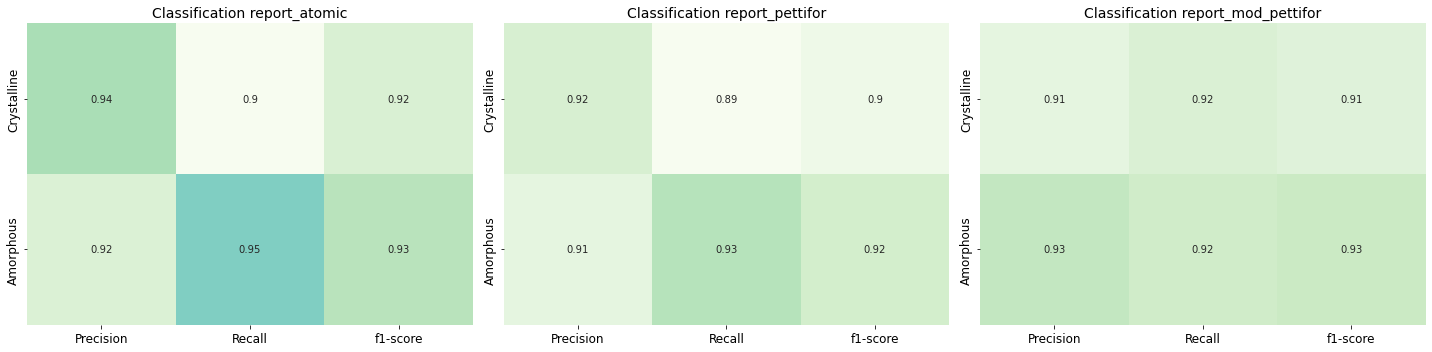

In [19]:
cuda = check_cuda()
comp_gfa, y_gfa = alt_read_gfa_dataset()
types = ['atomic','pettifor','mod_pettifor']
order_dict = {}
fig,ax = plt.subplots(1,3,figsize = (20,5))
ax = ax.ravel()
for i,k in enumerate(types):
    print('Representation : {}'.format(k))
    if k == 'atomic':
        comp, at_order  = get_atomic_number_features(comp_gfa)
        order_dict['atomic'] = at_order
    elif k == 'pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, pettifor_order)
        order_dict['pettifor'] = pettifor_order
    elif k == 'mod_pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, modified_pettifor_order)
        order_dict['mod_pettifor'] = modified_pettifor_order
    encoder1D = joblib.load(os.path.join(saveloc,'Encoder1D_{}.pt'.format(k)))
    if cuda:
        encoder1D = encoder1D.cuda()
    X_all = comp.astype('float32')
    y_all = np.array(y_gfa).reshape(-1,1).astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20,random_state = 0)
    if X_test.dtype != torch.float32:
        X_test = torch.from_numpy(X_test)
    if cuda:
        X_test =  X_test.cuda()
    y_predict = (encoder1D(X_test)).to('cpu').detach().numpy()
    target_names = ['Crystalline','Amorphous']
    clf = classification_report(y_test, np.round(y_predict), target_names=target_names,output_dict=True)
    

    g = sns.heatmap(pd.DataFrame(clf).iloc[:-1, :2].T, annot=True, vmax=1,vmin=0.9,cmap = 'GnBu', cbar=False, ax=ax[i])
    ax[i].set_yticklabels(labels = ['Crystalline','Amorphous'],fontsize=12)
    ax[i].set_xticklabels(labels = ['Precision','Recall','f1-score'],fontsize=12)
    ax[i].set_title('Classification report_{}'.format(types[i]),fontsize=14)
plt.tight_layout()